In [1]:
# Data preprocessing, math and plotting
import os
import numpy as np 
import pandas as pd 
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns 

# 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# ML
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, auc, classification_report, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import datetime
import random
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trevor.sauerbrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\trevor.sauerbrey\WPy64-3890\python-3.8.9.amd64\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
BATCH_SIZE=128
EPOCHS=25
EARLY_STOPPING_CRITERIA=3
DROPOUT_P=0.4
LEARNING_RATE = 0.01
MOMENTUM =0.9
MAX_ITER = 10000
N_JOBS = 4

In [3]:
data = pd.read_csv(r'data/olist_order_reviews_dataset.csv')

In [ ]:
# columns_to_keep = ['review_score', 'review_comment_message']
# data_drop = data.drop(columns=[col for col in data.columns if col not in columns_to_keep])
# data_drop

# data_drop_nans = data_drop.dropna(subset=['review_comment_message'])
# nan_counts = data_drop_nans.isnull().sum()
# print(nan_counts)
# data_drop_nans

In [9]:
def clean_data(data, column_text='review_comment_message', 
               column_score='review_score', 
               points_cut = [0, 2, 5], 
               classes = [0, 1]):
    
    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text','label']]
    
    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text' , column_score: 'label'})
    df_cat = df_cat[['text','label']]
    return df_bin ,df_cat


data_bin , data_cat = clean_data(data)

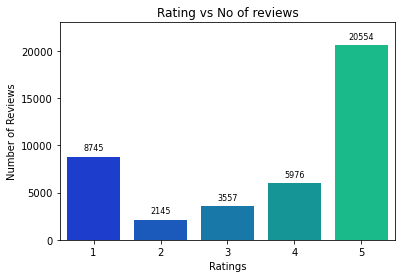

In [14]:
ax = sns.countplot(x=data_cat['label'], palette='winter')
plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.title('Rating vs No of reviews')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=8)
ax.set_ylim(0, 23000)  # Set the y-axis limit to 0 and 5000

plt.show()

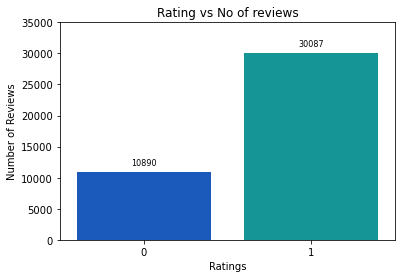

In [21]:
ax = sns.countplot(x=data_bin['label'], palette='winter')
plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.title('Rating vs No of reviews')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=8)
ax.set_ylim(0, 35000)  # Set the y-axis limit to 0 and 5000

plt.show()

In [29]:
grouped = data_bin.groupby(['label'])
sampled_df_1000 = grouped.apply(lambda x: x.sample(n=1000, random_state=42))
# random_state parameter is used to set the random seed for the sampling process, 
#which means that the same random samples will be selected each time the code is 
#run with random_state=42. This can be useful for debugging or ensuring reproducibility of results.

# Print the resulting samples
print(sampled_df_1000)

                                                          text label
label                                                               
0     66051  Ainda não recebi meu pedido e o prazo expirou ...     0
      7837   Estou com meu pedido desde 15/02, ainda não re...     0
      49034  Comprei dois relógios, um Relógio Feminino Bra...     0
      47294  No site tinha informando que tinha a cor que e...     0
      52029  Bom dia, ja fiz duas reclamações e ainda nao f...     0
...                                                        ...   ...
1     32264                     so demorou um pouco mais valeu     1
      19601                                          Recomendo     1
      49847  O produto é exatamente como o apresentado. Pel...     1
      58887  O produto de boa qualidade, entrega antes do p...     1
      77772  Realizei A Compra Depois De Muito Escolher No ...     1

[2000 rows x 2 columns]


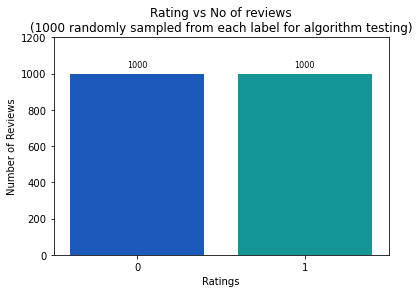

In [37]:
# all data
# ax = sns.countplot(x=data_bin['label'], palette='winter')

# randomly sampled 1000
ax = sns.countplot(x=sampled_df_1000['label'], palette='winter')

plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.title('Rating vs No of reviews' + '\n'  '(1000 randomly sampled from each label for algorithm testing)')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=8)
ax.set_ylim(0, 1200)  # Set the y-axis limit to 0 and 5000

plt.show()

# WORDCLOUD

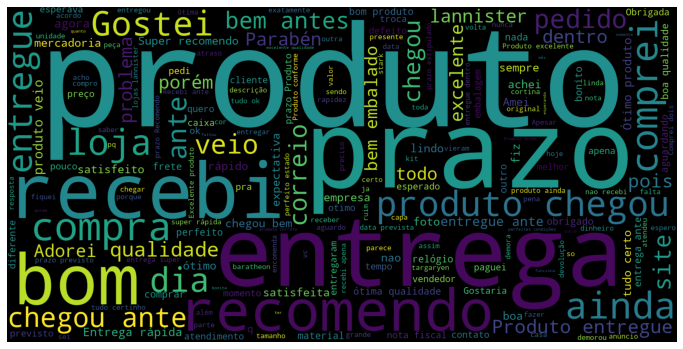

In [38]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
#                       # random testing sample
#                       width=1600, height=800).generate(' '.join(sampled_df_1000["text"]))
                      # all data
                      width=1600, height=800).generate(' '.join(data_bin["text"]))

fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [43]:
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [40]:
# all data
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

# # randomly sampled from dataset for testing to improve speed (1000 from each label)
# def split_test_train(sampled_df_1000, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
#     df_train = data.sample(frac = split_train, random_state = random_state)
#     df_test = data.drop(df_train.index)

    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for index, train in df_train.iterrows():
        X_train.append(str(train['text']))
        y_train.append(train['label'])

    for index, test in df_test.iterrows():
        X_test.append(str(test['text']))
        y_test.append(test['label'])

    y_train = np.array(y_train)
    y_test = np.array(y_test) 

    return X_train , y_train , X_test , y_test

X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [41]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)

def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):

    training_sequences = tokenizer.texts_to_sequences(X_train)
    X_train_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

    testing_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(testing_sequences,maxlen=max_length)

    return X_train_padded, X_test_padded

X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)

In [45]:
%%time
xgb = XGBClassifier(objective='binary:logistic' , 
                    use_label_encoder=False,  
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  92.96870233664816 %
Model score on Testing Data =  83.01403294691885 %
Wall time: 3.75 s


In [46]:
%%time
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

Model score on Training Data =  74.49820023183455 %
Model score on Testing Data =  73.31299572910311 %
Wall time: 4min 12s


# Confusion Matrices

In [ ]:
lr_cm=confusion_matrix(y_test, lr_preds )
nb_cm=confusion_matrix(y_test, nb_preds)
svm_cm=confusion_matrix(y_test, sv_preds)
nn_cm= confusion_matrix(y_test,y_preds)
rf_cm = confusion_matrix(y_test,rf_preds)
xg_cm = confusion_matrix(y_test,xg_preds)

plt.figure(figsize=(20,15))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,3,1)
plt.title("Neural Network")
sns.heatmap(nn_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,4)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,5)
plt.title("Random Forest Classifier")
sns.heatmap(rf_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,6)
plt.title("XGBosst Classifier")
sns.heatmap(xg_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# ROC-AUC Curves Comparison

In [ ]:
from sklearn.metrics import auc
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_nn, tpr_nn, _  = roc_curve(y_test, y_preds_prob)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

f, axes = plt.subplots(2,3,figsize=(20,15))
axes[0,0].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'LSTM')
axes[0,0].legend(loc='lower right', fontsize=13);


axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[1,0].legend(loc='lower right', fontsize=13)


axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[1,1].legend(loc='lower right', fontsize=13);


axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'XGB Classifier')
axes[1,2].legend(loc='lower right', fontsize=13);

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)